# Linear Temporal Logic

In [1]:
import spot
from buddy import bdd_ithvar

# Create a BDD dictionary for the Kripke structure
# Then create the Kripke structure
bdd_dict = spot.make_bdd_dict()
k = spot.make_kripke_graph(bdd_dict)

# Register atomic propositions
active = bdd_ithvar(k.register_ap("Active"))
interested = bdd_ithvar(k.register_ap("Interested"))
converted = bdd_ithvar(k.register_ap("Converted"))

# Create states with their labels
# Browsing: {Active}
browsing = k.new_state(active & -interested & -converted)

# Engaged: {Active, Interested}
engaged = k.new_state(active & interested & -converted)

# Disengaged: {}
disengaged = k.new_state(-active & -interested & -converted)

# Converted: {Active, Interested, Converted}
converted_state = k.new_state(active & interested & converted)

# Abandoned: {}
abandoned = k.new_state(-active & -interested & -converted)

k.set_state_names(["Browsing", "Engaged", "Disengaged", "Converted", "Abandoned"])


# Set initial state
k.set_init_state(browsing)

# Add transitions based on the relation R
k.new_edge(browsing, browsing)
k.new_edge(browsing, engaged)
k.new_edge(browsing, disengaged)
k.new_edge(browsing, abandoned)

k.new_edge(engaged, engaged)
k.new_edge(engaged, converted_state)
k.new_edge(engaged, disengaged)

k.new_edge(disengaged, disengaged)
k.new_edge(disengaged, abandoned)
k.new_edge(disengaged, browsing)

k.new_edge(converted_state, converted_state)
k.new_edge(abandoned, abandoned)


12

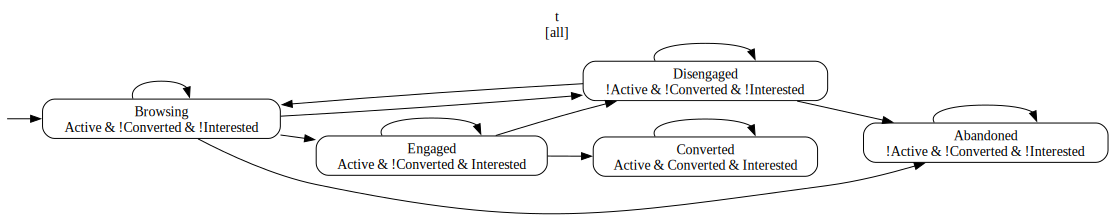

In [2]:
# Display the Kripke structure
k

## LTL Examples

In [3]:
def check_ltl_property(
    kripke: spot.kripke_graph, formula_str: str, description: str, bdd_dict=bdd_dict
) -> bool:
    """
    Check if an LTL property holds on a Kripke structure.
    Returns True if the property is verified, False if violated.
    This function first parses the LTL formula, translates its negation into an automaton,
    and then checks for counterexamples in the Kripke structure.
    """
    formula = spot.formula(formula_str)
    negated = spot.formula.Not(formula)
    automaton = spot.translate(negated, dict=bdd_dict)
    run = kripke.intersecting_run(automaton)  # Find a counterexample

    if run:
        print("\nProperty VIOLATED")
        print("\nCounterexample:")
        print(run)
        return False
    else:
        print("\nProperty VERIFIED")
        return True

In [4]:
# Example 1: Eventually operator. Check if a user will eventually become converted.
check_ltl_property(k, "F Converted", "Eventually the user will be converted")


Property VIOLATED

Counterexample:
Prefix:
Cycle:
  Browsing
  |  Active & !Converted & !Interested



False

In [5]:
# Example 2: Globally operator. Check if a user is always active.
check_ltl_property(k, "G Active", "The user is always active")


Property VIOLATED

Counterexample:
Prefix:
  Browsing
  |  Active & !Converted & !Interested
  Disengaged
  |  !Active & !Converted & !Interested
Cycle:
  Disengaged
  |  !Active & !Converted & !Interested



False

In [6]:
# Example 3: Until operator. Check if a user remains active until they become interested.
check_ltl_property(
    k, "Active U Interested", "Active holds until Interested becomes true"
)


Property VIOLATED

Counterexample:
Prefix:
Cycle:
  Browsing
  |  Active & !Converted & !Interested



False

In [7]:
# Example 4: Combining Globally operator and Eventually operator.
# Check if the user becomes interested infinitely often.
check_ltl_property(k, "G F Interested", "Infinitely often, the user is interested")


Property VIOLATED

Counterexample:
Prefix:
  Browsing
  |  Active & !Converted & !Interested
Cycle:
  Abandoned
  |  !Active & !Converted & !Interested



False

In [8]:
# Example 5: Implication operator. Check if being interested eventually leads to conversion.
check_ltl_property(
    k, "G (Interested -> F Converted)", "If interested, then eventually converted"
)


Property VIOLATED

Counterexample:
Prefix:
  Browsing
  |  Active & !Converted & !Interested
  Engaged
  |  Active & !Converted & Interested
Cycle:
  Engaged
  |  Active & !Converted & Interested



False

In [9]:
# Example 7: Safety Property. Check that once converted, the user stays converted.
check_ltl_property(
    k, "G (Converted -> G Converted)", "Once converted, always converted"
)


Property VERIFIED


True

In [10]:
# Example 8: Next operator. Check if from the initial state, the next state can be engaged.
check_ltl_property(
    k,
    "F (Active & X (Active & Interested))",
    "Eventually active and next state has both Active and Interested",
)


Property VIOLATED

Counterexample:
Prefix:
  Browsing
  |  Active & !Converted & !Interested
Cycle:
  Browsing
  |  Active & !Converted & !Interested



False